# Begin visualisations

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c

In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                    load_hapaxes.py
Project History.pdf        load_jaccard.py
README.md                  load_ngram_intersects.py
__pycache__                load_ngrams.py
arch                       load_relationships.py
authors.txt                make_3d_plot.py
auto_author_prediction.py  make_auto_scatterplot.py
begin.sh                   make_confusion.py
cleaning_splitting_scripts make_dash.py
cytoscape-layouts          make_histogram.py
database_ops.py            make_jumbo_dash.py
dh-trace-venv              make_lines.py
diagrams.ipynb             notebooks
do_svm.py                  poetry.lock
do_viz.sh                  predict_ops.py
explore                    projects
hapaxes_1tM.py             pyproject.toml
init_db.py                 requirements.txt
jan24                      show_previous_averages.py
load_alignments.py         util.py
load_authors_and_texts.py  utils
load_hapax_intersects.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../cleaning_splitting_scripts
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../cytoscape-layouts
../__pycache__
../load_hapaxes.py
../Project History.pdf
../jan24
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/sm-test')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
db_path

PosixPath('../projects/sm-test/db/sm-test.db')

In [10]:
db_path.exists()

True

In [11]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num
    FROM calculations AS calculation
        JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
        JOIN weights AS weight ON weight.weight_id = calculation.weight_id
        JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
        JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
        JOIN dirs AS dir_a ON dir_a.id = text_a.dir
        JOIN dirs AS dir_b ON dir_b.id = text_b.dir
        JOIN authors AS author_a ON author_a.id = text_a.author_id
        JOIN authors AS author_b ON author_b.id = text_b.author_id
        JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
    AND calculation.threshold = {threshold}
    AND dir_a.id <> dir_b.id
    LIMIT 100
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""
#add LIMIT 100 at bottom to limit results to first 100

In [12]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        calculation.same_author,\n        author_a.author_name AS a_author,\n        author_b.author_name AS b_author,\n        ROW_NUMBER() OVER (PARTITION BY weight.weight_id

In [13]:
con = sqlite3.connect(db_path)

In [14]:
#creates a view of the extensive query above and lets me work with it as if it's a tables

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

i = 0
con.execute("DROP TABLE IF EXISTS edges")
con.execute("DROP VIEW IF EXISTS edges")
con.execute("BEGIN TRANSACTION")
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        if i < 1:
            # Create the initial view
            create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
            with suppress(sqlite3.OperationalError):
                con.execute(create_view_query)
            i += 1
        else:
            append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
            con.execute(append_view_query)
            #TODO - check suppression of errors

con.commit()

In [15]:
all_results = []
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Execute the query and fetch results
        results = pd.read_sql(query, con)
        
        # Add results to the list
        all_results.append(results)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)

In [32]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)

1,000
       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
5244      1654       0.869       0.80          6       0.600      0.200   
9603       138       0.815       0.60         12       0.250      0.500   
765       2336       0.591       0.95          0       0.150      0.150   
12493     2956       0.821       0.80         15       0.275      0.450   
21090     2813       0.833       0.70         26       0.350      0.350   
...        ...         ...        ...        ...         ...        ...   
8487      2790       0.855       0.80         10       0.225      0.550   
8562      2300       0.880       0.85         10       0.225      0.550   
10535     1550       0.702       0.65         13       0.250      0.250   
17147     1717       0.780       0.75         21       0.325      0.325   
5020      1201       0.844       0.70          6       0.600      0.200   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_work_dir_id  \
5244        0.

In [17]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

1000
0.477 0.954


In [18]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [19]:
print(edges_df.sample(n=10))

       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
18290     2813       0.821       0.90         22       0.350      0.325   
2768      2417       0.547       0.75          3       0.175      0.175   
5214       983       0.823       0.80          6       0.600      0.200   
500         54       0.516       0.85          0       0.150      0.150   
16967     2403       0.741       0.65         21       0.325      0.325   
21255     2082       0.778       0.80         26       0.350      0.350   
7139      1594       0.708       0.95          8       0.200      0.200   
14278     2669       0.678       0.90         17       0.275      0.275   
15521     1387       0.712       0.75         19       0.300      0.300   
15690     2813       0.790       0.80         19       0.300      0.300   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_work_dir_id  \
18290       0.325     0.926327     0.073673    0.998907  ...              9   
2768        0.65

In [20]:
G

In [21]:
TEXT_FONT_SIZE = 8

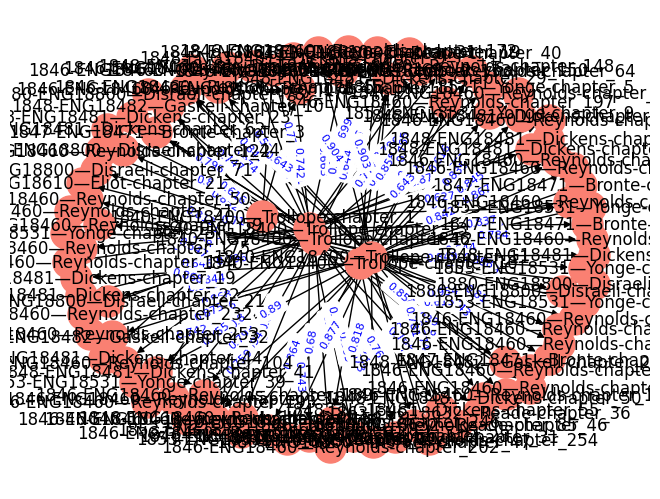

In [22]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [23]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [24]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.477, 0.954, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [25]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [26]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [27]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [28]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [29]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


116090